# Цель лабораторной работы
Изучить сложные способы подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

# Задание
Требуется выполнить следующие действия:

1. Выбрать набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите модель ближайших соседей для произвольно заданного гиперпараметра 
5. Оцените качество модели с помощью трех подходящих для задачи метрик.
6. Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.
7. Произведите подбор гиперпараметра с использованием GridSearchCV и кросс-валидации.
8. Сравните качество полученной модели с качеством модели, полученной в пункте 4.

# Ход выполнения работы
Подключим все необходимые библиотеки и настроим отображение графиков:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.datasets import load_wine
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")


In [ ]:
wine = load_wine()
df=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

## Предварительная подготовка данных

In [ ]:
data = df.copy()

In [ ]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


In [ ]:
df.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


## Разделение данных
Разделим данные на целевой столбец и признаки:

In [ ]:
y = df['target']  
X = df.drop('target', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state= 45)

In [ ]:
# Размер обучающей выборки
X_train.shape, y_train.shape

((133, 13), (133,))

In [ ]:
# Размер тестовой выборки
X_test.shape, y_test.shape

((45, 13), (45,))

In [ ]:
np.unique(y_train)

array([0., 1., 2.])

In [ ]:
np.unique(y_test)

array([0., 1., 2.])

## Подбор гиперпараметра *K*

Попробуем метод ближайших соседей с гиперпараметром K = 2:

In [ ]:
reg_2 = KNeighborsClassifier(n_neighbors=2)
reg_2.fit(X_train, y_train)
target1_train = reg_2.predict(X_train)
target1_test = reg_2.predict(X_test)

In [ ]:
# значение метрики accuracy на обучающей и тестовой выборках построенной модели
print(accuracy_score(y_train, target1_train), accuracy_score(y_test, target1_test))
print(classification_report(y_train, target1_train), classification_report(y_test, target1_test))

0.8646616541353384 0.5555555555555556
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        47
         1.0       0.83      0.91      0.87        54
         2.0       1.00      0.59      0.75        32

    accuracy                           0.86       133
   macro avg       0.90      0.83      0.84       133
weighted avg       0.88      0.86      0.86       133
               precision    recall  f1-score   support

         0.0       0.73      0.92      0.81        12
         1.0       0.50      0.76      0.60        17
         2.0       0.25      0.06      0.10        16

    accuracy                           0.56        45
   macro avg       0.49      0.58      0.51        45
weighted avg       0.47      0.56      0.48        45



In [ ]:
# Оценка модели с применением кросс-валидации
scores = cross_val_score(reg_2, X, y, cv=25)
np.mean(scores)

0.6857142857142857

In [ ]:
# Подбор гиперпараметра на основе решетчатого поиска и кросс-валидации
n_range = np.array(range(5,70,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])}]

In [ ]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=25, scoring='accuracy')
clf_gs.fit(X, y)
clf_gs.best_params_

CPU times: user 2.67 s, sys: 13.6 ms, total: 2.68 s
Wall time: 2.82 s


{'n_neighbors': 40}

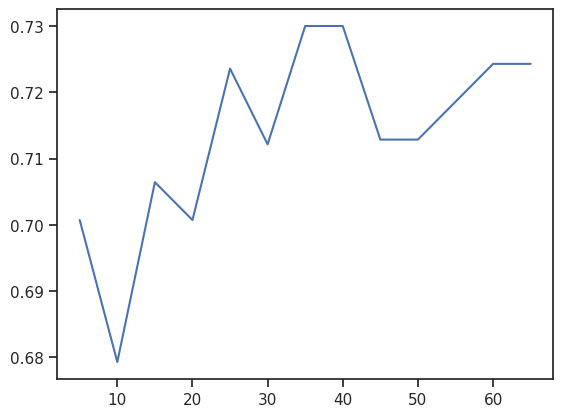

In [ ]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

In [ ]:
%%time
# Повторный подбор
n_range = np.array(range(34,46,1))
tuned_parameters = [{'n_neighbors': n_range}]
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=25, scoring='accuracy')
clf_gs.fit(X, y)
clf_gs.best_params_

CPU times: user 1.65 s, sys: 10.3 ms, total: 1.66 s
Wall time: 1.68 s


{'n_neighbors': 40}

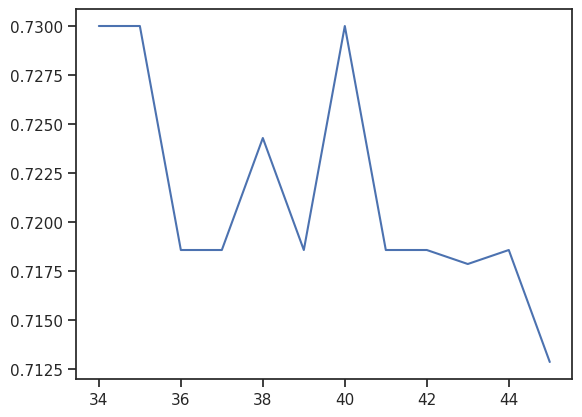

In [ ]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

In [ ]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров (k=40)
clf_gs.best_estimator_.fit(X_train, y_train)
target2_train = clf_gs.best_estimator_.predict(X_train)
target2_test = clf_gs.best_estimator_.predict(X_test)
# Новое качество модели
print(accuracy_score(y_train, target2_train), accuracy_score(y_test, target2_test))
print(classification_report(y_train, target2_train), classification_report(y_test, target2_test))

0.7368421052631579 0.6222222222222222
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88        47
         1.0       0.77      0.69      0.73        54
         2.0       0.51      0.59      0.55        32

    accuracy                           0.74       133
   macro avg       0.72      0.72      0.72       133
weighted avg       0.75      0.74      0.74       133
               precision    recall  f1-score   support

         0.0       0.83      0.83      0.83        12
         1.0       0.62      0.59      0.61        17
         2.0       0.47      0.50      0.48        16

    accuracy                           0.62        45
   macro avg       0.64      0.64      0.64        45
weighted avg       0.63      0.62      0.62        45



In [ ]:
# значение метрики accuracy до подбора гиперпараметра
print(accuracy_score(y_train, target1_train), accuracy_score(y_test, target1_test))
print(classification_report(y_train, target1_train), classification_report(y_test, target1_test))

0.8646616541353384 0.5555555555555556
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        47
         1.0       0.83      0.91      0.87        54
         2.0       1.00      0.59      0.75        32

    accuracy                           0.86       133
   macro avg       0.90      0.83      0.84       133
weighted avg       0.88      0.86      0.86       133
               precision    recall  f1-score   support

         0.0       0.73      0.92      0.81        12
         1.0       0.50      0.76      0.60        17
         2.0       0.25      0.06      0.10        16

    accuracy                           0.56        45
   macro avg       0.49      0.58      0.51        45
weighted avg       0.47      0.56      0.48        45

